# ANN to Predict Valence

Trying this again, all channels

Setup: Javascript and ipynb stuff

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## Load Functions

In [9]:
from fastai.vision import *
import os
import numpy as np
import pandas as pd
import pickle
import random
from sklearn import preprocessing

In [10]:
path=pathlib.Path('/media/tris/tris_files/EEG_datasets/DMD')
path

PosixPath('/media/tris/tris_files/EEG_datasets/DMD')

## Load Original Data Labels

In [20]:
path = '/media/tris/tris_files/EEG_datasets/data_preprocessed_python/s01.dat'
df_read = pickle.load(open(path, 'rb'), encoding='latin1')
labels=df_read['labels']
df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
df=df_tmp
for n in range (2,10):
    path = '/media/tris/tris_files/EEG_datasets/data_preprocessed_python/s0'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True)
for n in range (10,33):
    path = '/media/tris/tris_files/EEG_datasets/data_preprocessed_python/s'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True) 

In [21]:
filenames=[]
subject_labels=[]
for n in range (0,9):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
for n in range (9,32):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
df['file_name']=filenames
df['subject_label']=subject_labels
# df=df[['file_name','valence','arousal','dominance','liking']]
df=df[['file_name','subject_label','valence']]
df.tail()

,file_name,subject_label,valence
1275,S32T36,32,3.91
1276,S32T37,32,2.81
1277,S32T38,32,3.05
1278,S32T39,32,3.99
1279,S32T40,32,7.15


In [49]:
valence = df[['valence']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
v_scaled = min_max_scaler.fit_transform(valence)
v_normalized = pd.DataFrame(v_scaled, columns=['v_normal'])
df_learn=pd.concat([df[['file_name']],v_normalized], axis=1)
df_learn.head()

,file_name,v_normal
0,S1T1,0.83875
1,S1T2,0.88750
2,S1T3,0.94750
3,S1T4,0.49250
4,S1T5,0.74500


In [50]:
path=pathlib.Path('/media/tris/tris_files/EEG_datasets/DMD')
path

PosixPath('/media/tris/tris_files/EEG_datasets/DMD')

In [51]:
df_learn.to_csv(path/'labels_proc_val.csv', index=False)

In [52]:
df = pd.read_csv(path/'labels_proc_val.csv') #load labels
df.tail()

,file_name,v_normal
1275,S32T36,0.36375
1276,S32T37,0.22625
1277,S32T38,0.25625
1278,S32T39,0.37375
1279,S32T40,0.76875


## Data loader

In [54]:
src = (ImageList.from_csv(path, 'labels_proc_val.csv', folder='heatmaps_32ch', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(cols=['v_normal']))

In [55]:
tfms=[]

In [56]:
data = (src.transform(tfms, size=400)
        .databunch(bs=4).normalize())

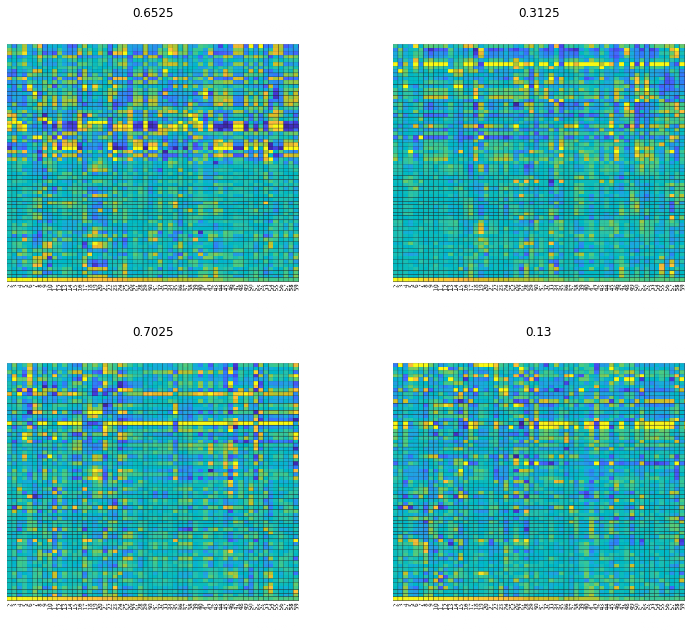

In [57]:
data.show_batch(rows=4, figsize=(12,9))

## Setup Network

In [58]:
learn = cnn_learner(data, models.resnet50, metrics=root_mean_squared_error)

In [59]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 200, 200]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 200, 200]       128        True      
______________________________________________________________________
ReLU                 [64, 200, 200]       0          False     
______________________________________________________________________
MaxPool2d            [64, 100, 100]       0          False     
______________________________________________________________________
Conv2d               [64, 100, 100]       4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 100, 100]       128        True      
______________________________________________________________________
Conv2d               [64, 100, 100]       36,864     False     
___________________________________________________

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


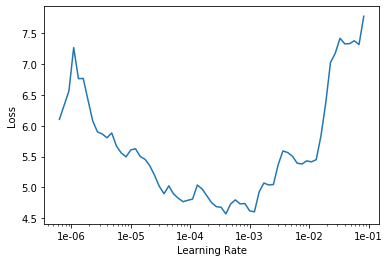

In [60]:
learn.lr_find()
learn.recorder.plot()

## Train last layers

In [61]:
lr = 2e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.692149,2.977913,1.620978,00:31
1,0.834894,0.249043,0.475787,00:31
2,0.278848,0.122405,0.337137,00:31
3,0.120611,0.096931,0.295003,00:31
4,0.103168,0.092942,0.289932,00:31


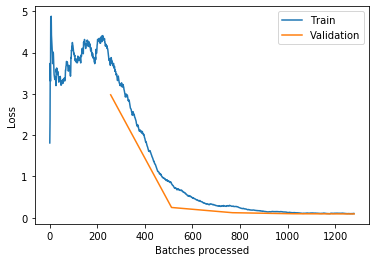

In [62]:
learn.recorder.plot_losses()

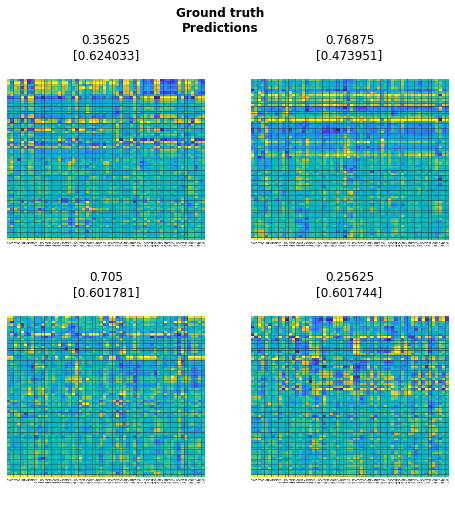

In [63]:
learn.show_results()

## Train the whole network

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


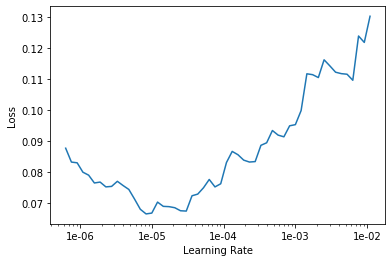

In [64]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [65]:
lr = 8e-6
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.088587,0.090627,0.286948,00:43
1,0.092554,0.084271,0.275477,00:43
2,0.091924,0.087299,0.281254,00:43
3,0.089773,0.088510,0.284902,00:42
4,0.094052,0.086654,0.280771,00:43


## Interpret and Results

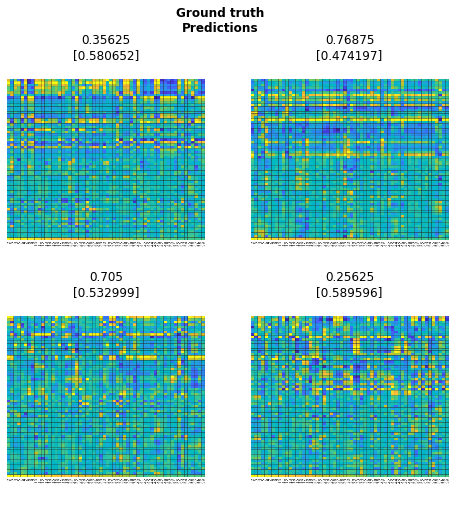

In [66]:
learn.show_results()